### 下載股票資訊並繪製成K線圖

載入套件

In [18]:
import pandas as pd
import yfinance as yf
import datetime
import mplfinance as mpf
import requests,json

In [19]:
def KValue(rsv):
    global K
    K = (2/3) * K + (1/3) * rsv
    return K

def DValue(k):
    global D
    D = (2/3) * D + (1/3) * k
    return D
def twse_data(r_data:str):
    data = requests.get(f'https://www.twse.com.tw/rwd/zh/fund/T86?date={r_data}&selectType=ALLBUT0999&response=json&_=1687757740217')
    data_json = json.loads(data.text)
    df = pd.DataFrame(data_json['data'],columns=data_json['fields'])
    df = df.replace(',','', regex=True)
    return df


繪製2330 台積電 K線圖

[*********************100%%**********************]  1 of 1 completed


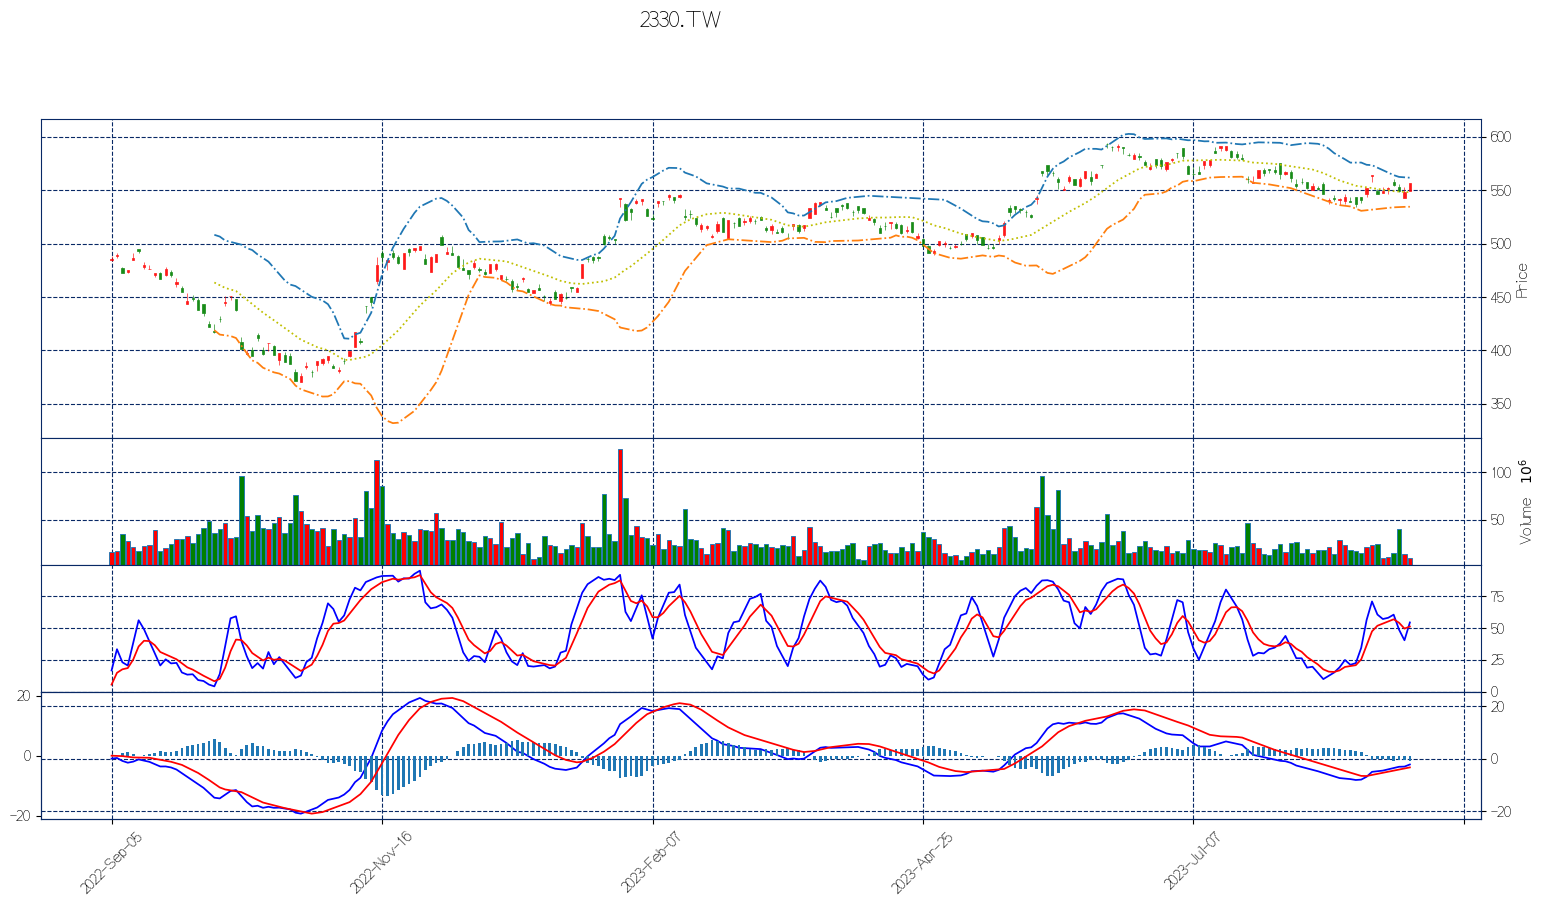

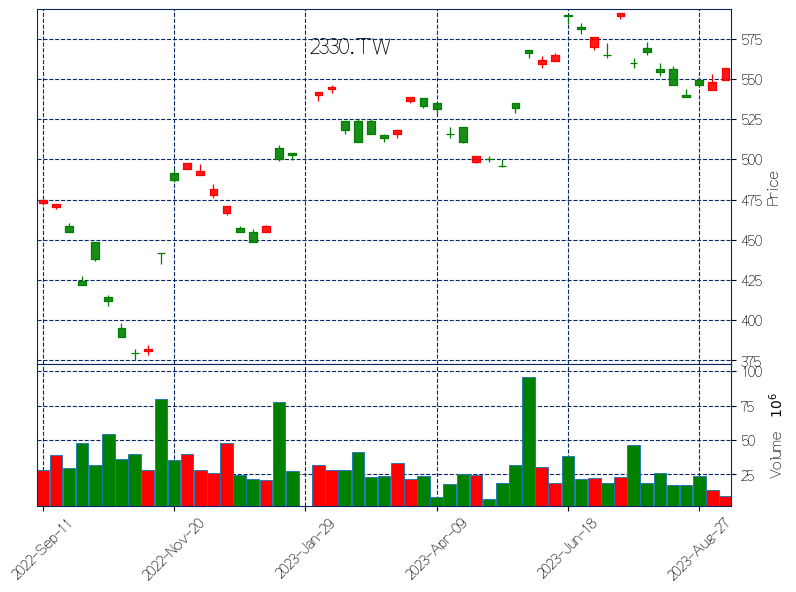

In [20]:
stock = '2330.TW'
today = datetime.date.today()
dateStart = (today - datetime.timedelta(days=365)).strftime('%Y-%m-%d')
dateEnd = today.strftime('%Y-%m-%d')  
df = yf.download(stock, start=dateStart, end=dateEnd)
df.columns = ['open','high','low','close','adj Close','volume']
dfR = df.copy()
df['9MAX'] = df['high'].rolling('9D').max()
df['9MIN'] = df['low'].rolling('9D').min()
# 計算每日 RSV 值
df['RSV'] = 100 * (df['close'] - df['9MIN']) / (df['9MAX'] - df['9MIN'])

# 計算KD
K = 0
df['K'] = df['RSV'].apply(KValue)

# 計算 D 值
D = 0
df['D'] = df['K'].apply(DValue)

exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
# 計算MACD 和 Signal line
df['MACD'] = exp1 - exp2
df['Signal line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 計算 布林指標
df['BB'] = df['close'].rolling(20).mean()
df['UB'] = df['BB'] + 2*df['close'].rolling(20).std()
df['LB'] = df['BB'] - 2*df['close'].rolling(20).std()

mc = mpf.make_marketcolors(up='red',down='green',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='starsandstripes',marketcolors=mc)

add_plot =[mpf.make_addplot(df[['UB','LB']],linestyle='dashdot'),
           mpf.make_addplot(df['BB'],linestyle='dotted',color='y'),
           mpf.make_addplot(df["K"],panel= 2,color="b"),
           mpf.make_addplot(df["D"],panel= 2,color="r"),
           mpf.make_addplot(df["MACD"],panel= 3,color="b"),
           mpf.make_addplot(df["Signal line"],panel= 3,color="r"),
           mpf.make_addplot(df["Signal line"]-df["MACD"],panel= 3,type='bar',width=0.5),]
kwargs = dict(type='candle', volume = True,figsize=(20, 10),title = stock, style=s,addplot=add_plot)
mpf.plot(df, **kwargs)

df1 = df.resample('w').last()
mpf.plot(df1, type='candle', style=s, volume=True, title=stock, tight_layout=True)

漲幅最大前十名

In [22]:
dfR['close_pct %'] = round(((dfR['adj Close'] - dfR['adj Close'].shift(1)) / dfR['adj Close'].shift(1))*100,2)
dfR.nlargest(10, 'close_pct %')

,open,high,low,close,adj Close,volume,close_pct %
Date,,,,,,,
2022-11-11,441.5,442.0,435.0,441.5,434.576080,80016195,8.34
2023-01-30,542.0,543.0,534.0,543.0,537.560852,124428936,7.95
2022-11-15,465.0,487.0,462.0,480.0,472.472290,113379796,7.87
2023-01-09,468.0,481.0,467.5,481.0,476.181885,46666263,4.91
2022-11-09,403.5,417.0,403.5,417.0,410.460297,52260831,4.51
2022-10-14,414.5,416.0,409.0,412.0,405.538727,54504366,4.30
2023-05-26,568.0,568.0,563.0,566.0,563.362000,95808471,4.24
2022-10-05,444.5,451.0,442.0,445.0,438.021179,46496536,3.73
2023-05-25,542.0,545.0,537.0,543.0,540.469238,63827245,3.43


獲取三日法人買賣超資料

In [ ]:
today = datetime.date.today()
control = 0
print('三大法人篩選\n')
for i in range(1,11):
    if control <=2 :
        try:
            date_target = today - datetime.timedelta(days=(i))
            convert_date = date_target.strftime('%Y%m%d')
            print(convert_date)
            data = twse_data(convert_date)
            # 獲取買超前50名
            d_b = data.head(50)
            # 獲取賣超前50名
            d_s = data.tail(50)
            if control == 0:
                resultB = set(d_b[u'證券代號'].to_list())
                resultS = set(d_s[u'證券代號'].to_list())
            else:
                resultB = resultB.intersection(set(d_b[u'證券代號'].to_list()))
                resultS = resultS.intersection(set(d_s[u'證券代號'].to_list()))
            control += 1
        except: 
            continue
    else:
        break
resultB = list(resultB)
resultS = list(resultS)
dfB = pd.DataFrame()
dfB['日期'] = len(resultB)*[today]
dfB['代號'] = resultB
dfB['鉅亨網連結'] = dfB['代號'].apply(lambda x:f"https://www.cnyes.com/twstock/{x}")
dfS = pd.DataFrame()
dfS['日期'] = len(resultS)*[today]
dfS['代號'] = resultS
dfS['鉅亨網連結'] = dfS['代號'].apply(lambda x:f"https://www.cnyes.com/twstock/{x}")

三大法人篩選

20230904
20230903
20230902
20230901
20230831


法人連三日買超

In [23]:
dfB

,日期,代號,鉅亨網連結
0,2023-09-05,2402,https://www.cnyes.com/twstock/2402
1,2023-09-05,00893,https://www.cnyes.com/twstock/00893
2,2023-09-05,00885,https://www.cnyes.com/twstock/00885
3,2023-09-05,00715L,https://www.cnyes.com/twstock/00715L
4,2023-09-05,00712,https://www.cnyes.com/twstock/00712


法人連三日賣超

In [24]:
dfS

,日期,代號,鉅亨網連結
0,2023-09-05,3715,https://www.cnyes.com/twstock/3715
1,2023-09-05,00673R,https://www.cnyes.com/twstock/00673R
2,2023-09-05,1101,https://www.cnyes.com/twstock/1101
3,2023-09-05,00919,https://www.cnyes.com/twstock/00919
4,2023-09-05,2834,https://www.cnyes.com/twstock/2834
5,2023-09-05,2376,https://www.cnyes.com/twstock/2376
6,2023-09-05,00929,https://www.cnyes.com/twstock/00929
